In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.model_selection import train_test_split

import joblib
pd.set_option('display.max_columns', None)


from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline

from sklearn.metrics import r2_score,mean_squared_error


from feature_engine.imputation import ( MeanMedianImputer,
                                       CategoricalImputer,
                                       AddMissingIndicator

)


from feature_engine.transformation import (YeoJohnsonTransformer,
                                           LogTransformer

)


from feature_engine.encoding import (RareLabelEncoder,
                                     OrdinalEncoder

)


from feature_engine.selection import DropFeatures
from feature_engine.wrappers  import SklearnTransformerWrapper
import preprocessors as pp

In [45]:
data= pd.read_csv(r'/Users/saurabhverma/Downloads/train.csv')



data['MSSubClass']= data['MSSubClass'].astype('O')

x_train, x_test,y_train, y_test= train_test_split(data.drop(['Id', 'SalePrice'], axis= 1), data['SalePrice'],test_size= .1, random_state=0)

In [46]:
y_train= np.log(y_train)
y_test= np.log(y_test)

In [47]:
# categorical variables with NA in train set
CATEGORICAL_VARS_WITH_NA_FREQUENT = ['BsmtQual', 'BsmtExposure',
                                     'BsmtFinType1', 'GarageFinish']


CATEGORICAL_VARS_WITH_NA_MISSING = ['FireplaceQu']


# numerical variables with NA in train set
NUMERICAL_VARS_WITH_NA = ['LotFrontage']


TEMPORAL_VARS = ['YearRemodAdd']
REF_VAR = "YrSold"

# this variable is to calculate the temporal variable,
# can be dropped afterwards
DROP_FEATURES = ["YrSold"]

# variables to log transform
NUMERICALS_LOG_VARS = ["LotFrontage", "1stFlrSF", "GrLivArea"]


# variables to binarize
BINARIZE_VARS = ['ScreenPorch']

# variables to map
QUAL_VARS = ['ExterQual', 'BsmtQual',
             'HeatingQC', 'KitchenQual', 'FireplaceQu']

EXPOSURE_VARS = ['BsmtExposure']

FINISH_VARS = ['BsmtFinType1']

GARAGE_VARS = ['GarageFinish']

FENCE_VARS = ['Fence']


# categorical variables to encode
CATEGORICAL_VARS = ['MSSubClass',  'MSZoning',  'LotShape',  'LandContour',
                    'LotConfig', 'Neighborhood', 'RoofStyle', 'Exterior1st',
                    'Foundation', 'CentralAir', 'Functional', 'PavedDrive',
                    'SaleCondition']


# variable mappings
QUAL_MAPPINGS = {'Po': 1, 'Fa': 2, 'TA': 3,
                 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

EXPOSURE_MAPPINGS = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

FINISH_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1,
                   'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

GARAGE_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}


# the selected variables
FEATURES = [
    'MSSubClass',
    'MSZoning',
    'LotFrontage',
    'LotShape',
    'LandContour',
    'LotConfig',
    'Neighborhood',
    'OverallQual',
    'OverallCond',
    'YearRemodAdd',
    'RoofStyle',
    'Exterior1st',
    'ExterQual',
    'Foundation',
    'BsmtQual',
    'BsmtExposure',
    'BsmtFinType1',
    'HeatingQC',
    'CentralAir',
    '1stFlrSF',
    '2ndFlrSF',
    'GrLivArea',
    'BsmtFullBath',
    'HalfBath',
    'KitchenQual',
    'TotRmsAbvGrd',
    'Functional',
    'Fireplaces',
    'FireplaceQu',
    'GarageFinish',
    'GarageCars',
    'GarageArea',
    'PavedDrive',
    'WoodDeckSF',
    'ScreenPorch',
    'SaleCondition',
    # this one is only to calculate temporal variable:
    "YrSold",
]

In [48]:
x_train=x_train[FEATURES]
x_test=x_test[FEATURES]

In [49]:
x_train.shape, x_test.shape

((1314, 37), (146, 37))

In [50]:
price_pipe = Pipeline([
    ('missing_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARS_WITH_NA_MISSING
    )),

    ('frequent_imputation', CategoricalImputer(
        imputation_method='frequent', variables= CATEGORICAL_VARS_WITH_NA_FREQUENT
    )),

    ('missing_indicator', AddMissingIndicator(
        variables= NUMERICAL_VARS_WITH_NA
    ) ),

    ('mean_imputation', MeanMedianImputer(
        imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA
    )),

    #temporal transformation

    ('elapsed_years', pp.TemporalVariableTransformers(variables=TEMPORAL_VARS, reference_variable=REF_VAR)),

    ('drop_feature', DropFeatures(features_to_drop=[REF_VAR])),

    #variable transformations

    ('log', LogTransformer(variables=NUMERICALS_LOG_VARS)),

    ('binarizer', SklearnTransformerWrapper(
        transformer=Binarizer(threshold=0), variables=BINARIZE_VARS)),
    

    #mapper

    ('mapper_qual', pp.Mapper(variables= QUAL_VARS, mappings=QUAL_MAPPINGS)),

    ('mapper_exposure', pp.Mapper(
        variables=EXPOSURE_VARS, mappings=EXPOSURE_MAPPINGS)),

    ('mapper_finish', pp.Mapper(
        variables=FINISH_VARS, mappings=FINISH_MAPPINGS)),

    ('mapper_garage', pp.Mapper(
        variables=GARAGE_VARS, mappings=GARAGE_MAPPINGS)),
    
    
    ('Rare_encoding', RareLabelEncoder(
            tol=0.01, variables=CATEGORICAL_VARS, n_categories=1
        )),
    #ORDINAL ENCODING
    ('CATEGORICAL_ENCODER', OrdinalEncoder(
        encoding_method='ordered', variables=CATEGORICAL_VARS
    )),

     ('scaler', MinMaxScaler()),
#     ('selector', SelectFromModel(Lasso(alpha=0.001, random_state=0))),
    
   
    ('Lasso', Lasso(alpha=0.001, random_state=0)),

    
])

In [51]:
price_pipe.fit(x_train,y_train)

/Users/saurabhverma/Library/Python/3.9/lib/python/site-packages/feature_engine/transformation/log.py:167: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[7.29029288 6.95939851 7.46851327 ... 7.18387072 7.35051617 7.08590146]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, self.variables_] = np.log(X.loc[:, self.variables_])
/Users/saurabhverma/Library/Python/3.9/lib/python/site-packages/feature_engine/transformation/log.py:167: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[7.29029288 6.95939851 7.46851327 ... 7.55066124 7.35051617 7.51697722]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, self.variables_] = np.log(X.loc[:, self.variables_])


Pipeline(steps=[('missing_imputation',
                 CategoricalImputer(variables=['FireplaceQu'])),
                ('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['BsmtQual', 'BsmtExposure',
                                               'BsmtFinType1',
                                               'GarageFinish'])),
                ('missing_indicator',
                 AddMissingIndicator(variables=['LotFrontage'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method=...
                                             'Foundation', 'CentralAir',
                                             'Functional', 'PavedDrive',
                                             'SaleCondition'])),
                ('CATEGORICAL_ENCODER',
                 OrdinalEncoder(variables=['MSSubClass', 'MSZoning', 'LotShape',
                                           'LandContour', 'LotConfig',
                                           'Neighborhood', 'RoofStyle',
                                           'Exterior1st', 'Foundation',
                                           'CentralAir', 'Functional',
                                           'PavedDrive', 'SaleCondition'])),
                ('scaler', MinMaxScaler()),
                ('Lasso', Lasso(alpha=0.001, random_state=0))])

In [52]:

# evaluate the model:
# ====================

# make predictions for train set
pred = price_pipe.predict(x_train)

# determine mse, rmse and r2
print('train mse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred)))))
print('train rmse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred), squared=False))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred))))
print()

# make predictions for test set
pred = price_pipe.predict(x_test)

# determine mse, rmse and r2
print('test mse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred)))))
print('test rmse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred), squared=False))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred))))
print()

print('Average house price: ', int(np.exp(y_train).median()))

train mse: 781396630
train rmse: 27953
train r2: 0.8748530315439075

test mse: 1060769014
test rmse: 32569
test r2: 0.8456415571208442

Average house price:  163000


/Users/saurabhverma/Library/Python/3.9/lib/python/site-packages/feature_engine/transformation/log.py:167: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[7.29029288 6.95939851 7.46851327 ... 7.18387072 7.35051617 7.08590146]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, self.variables_] = np.log(X.loc[:, self.variables_])
/Users/saurabhverma/Library/Python/3.9/lib/python/site-packages/feature_engine/transformation/log.py:167: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[7.29029288 6.95939851 7.46851327 ... 7.55066124 7.35051617 7.51697722]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, self.variables_] = np.log(X.loc[:, self.variables_])
/Users/saurabhverma/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:483: Futu

In [56]:
joblib.dump(price_pipe, 'price_pipe.joblib')

['price_pipe.joblib']

Predicting on new data

In [57]:
data= pd.read_csv(r'/Users/saurabhverma/Downloads/test.csv')

In [58]:
data.drop(['Id'], axis=1,inplace=True)

data['MSSubClass']= data['MSSubClass'].astype('O')

data= data[FEATURES]

new_vars_with_na= [var for var in FEATURES if var not in CATEGORICAL_VARS_WITH_NA_FREQUENT +
    CATEGORICAL_VARS_WITH_NA_MISSING +
    NUMERICAL_VARS_WITH_NA
    and data[var].isnull().sum() > 0 ]

new_vars_with_na

['MSZoning',
 'Exterior1st',
 'BsmtFullBath',
 'KitchenQual',
 'Functional',
 'GarageCars',
 'GarageArea']

In [60]:
data[new_vars_with_na].isna().mean()

MSZoning        0.002742
Exterior1st     0.000685
BsmtFullBath    0.001371
KitchenQual     0.000685
Functional      0.001371
GarageCars      0.000685
GarageArea      0.000685
dtype: float64

In [61]:
data.dropna(subset=new_vars_with_na, inplace=True)

In [62]:
new_preds= price_pipe.predict(data)

/Users/saurabhverma/Library/Python/3.9/lib/python/site-packages/feature_engine/transformation/log.py:167: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[6.79794041 7.19218206 6.83303173 ... 7.10987946 6.87729607 6.90374726]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, self.variables_] = np.log(X.loc[:, self.variables_])
/Users/saurabhverma/Library/Python/3.9/lib/python/site-packages/feature_engine/transformation/log.py:167: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[6.79794041 7.19218206 7.39572161 ... 7.10987946 6.87729607 7.60090246]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[:, self.variables_] = np.log(X.loc[:, self.variables_])


<Axes: ylabel='Frequency'>

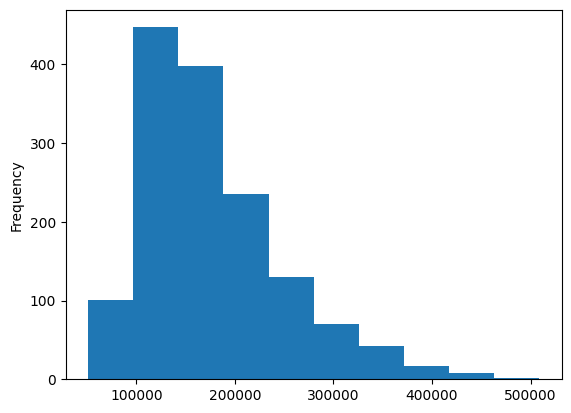

In [64]:
pd.Series(np.exp(new_preds)).plot(kind='hist')

In [65]:
# now ready for deployment